In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from itertools import product
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
import warnings
import json
warnings.filterwarnings("ignore")

def RMSE(series_true, series_predicted):
    return sum((series_true - series_predicted)**2 / len(series_true))**0.5

In [2]:
shops = pd.read_csv('data/shops.csv', index_col='shop_id')
shops_1 = pd.read_csv('data/shops_1.csv')
items = pd.read_csv('data/items.csv', index_col='item_id')
item_cat_names = pd.read_csv('data/item_categories.csv', index_col='item_category_id')
item_cats = pd.read_csv('data/item_categories_1.csv')
super_category = pd.read_csv('data/super_category.csv')
category = pd.read_csv('data/category.csv')
city = pd.read_csv('data/city.csv')
shop_name = pd.read_csv('data/shop_name.csv')
shop_type = pd.read_csv('data/shop_type.csv')

In [3]:
all_series = pd.read_pickle('data/all_series.pickle', compression='bz2')

In [4]:
all_month_names = [datetime.datetime(2013 + i // 12, i % 12 + 1, 1).strftime('%B, %Y') for i in range(34)]
def plot_series(shop_id, item_id):
    plt.figure(figsize=(12, 7))
    plt.plot(all_series[(all_series.shop_id == shop_id) & (all_series.item_id == item_id)].iloc[0, 2:].values)
    plt.xticks(ticks=range(34), labels=all_month_names, rotation=80)
    plt.ylabel('month sales count')
    plt.show()

In [5]:
X = pd.read_csv('data/X_without_target_encoding.csv')
y = pd.read_csv('data/y_without_target_encoding.csv').item_cnt

In [6]:
types = {
    'date_block_num': 'int8',
    'shop_id': 'int8',
    'item_id': 'int16',
    'item_category_id': 'int8',
    'super_category': 'int8',
    'category': 'int8',
    'city': 'int8',
    'shop_type': 'int8',
    'shop_name': 'int8'
}
types.update({
    f'item_cnt_lag{i}': 'int8' for i in range(1, 13)
})

In [7]:
X = X.astype(types)

In [8]:
X.rename(columns={
    col: f'{col}_id' for col in ['super_category', 'category', 'city', 'shop_type', 'shop_name']
}, inplace=True)

In [9]:
X_without_ids = X.drop(columns=['shop_id', 'item_id', 'item_category_id'])

In [10]:
X_train = X_without_ids[X_without_ids.date_block_num < 33]
y_train = y[X.date_block_num < 33]

X_val = X[X.date_block_num == 33]
y_val = y[X.date_block_num == 33]

In [11]:
lgbm = LGBMRegressor(max_depth=12, n_estimators=1000)
lgbm.fit(X_train,
         y_train,
         eval_set=[(X_val.drop(columns=['shop_id', 'item_id', 'item_category_id']), y_val)],
         eval_metric='l2',
         early_stopping_rounds=20,
         verbose=-1,
         feature_name=X_train.columns.to_list(),
         categorical_feature=X_train.columns.to_list()[:6])

LGBMRegressor(max_depth=12, n_estimators=1000)

In [12]:
X_val['predicted'] = lgbm.predict(X_val.drop(columns=['shop_id', 'item_id', 'item_category_id'])).clip(0, 20)
X_val['true'] = y_val
X_val.head()

,date_block_num,shop_id,item_id,item_category_id,super_category_id,category_id,city_id,shop_type_id,shop_name_id,item_cnt_lag1,...,item_cnt_lag5,item_cnt_lag6,item_cnt_lag7,item_cnt_lag8,item_cnt_lag9,item_cnt_lag10,item_cnt_lag11,item_cnt_lag12,predicted,true
986860,33,2,31,37,9,2,1,7,23,0,...,0,0,0,0,0,0,0,0,0.046493,1
986861,33,2,486,73,13,1,1,7,23,1,...,0,1,2,3,0,0,2,1,0.532414,3
986862,33,2,787,49,10,42,1,7,23,0,...,0,0,1,0,0,0,0,0,0.027706,1
986863,33,2,794,73,13,1,1,7,23,0,...,0,0,0,0,0,0,0,0,0.059601,1
986864,33,2,968,40,9,7,1,7,23,0,...,0,0,0,0,0,0,0,0,0.047361,1


In [13]:
RMSE(X_val.true, X_val.predicted)

0.9222498764802931

In [14]:
X_val['error'] = X_val.true - X_val.predicted
X_val.head(5)

,date_block_num,shop_id,item_id,item_category_id,super_category_id,category_id,city_id,shop_type_id,shop_name_id,item_cnt_lag1,...,item_cnt_lag6,item_cnt_lag7,item_cnt_lag8,item_cnt_lag9,item_cnt_lag10,item_cnt_lag11,item_cnt_lag12,predicted,true,error
986860,33,2,31,37,9,2,1,7,23,0,...,0,0,0,0,0,0,0,0.046493,1,0.953507
986861,33,2,486,73,13,1,1,7,23,1,...,1,2,3,0,0,2,1,0.532414,3,2.467586
986862,33,2,787,49,10,42,1,7,23,0,...,0,1,0,0,0,0,0,0.027706,1,0.972294
986863,33,2,794,73,13,1,1,7,23,0,...,0,0,0,0,0,0,0,0.059601,1,0.940399
986864,33,2,968,40,9,7,1,7,23,0,...,0,0,0,0,0,0,0,0.047361,1,0.952639


In [15]:
errors = X_val.groupby('true')\
        .agg({'error':['mean', lambda value: (value**2).mean()**0.5, 'count']})['error']\
        .rename(columns={'<lambda_0>': 'rmse'})

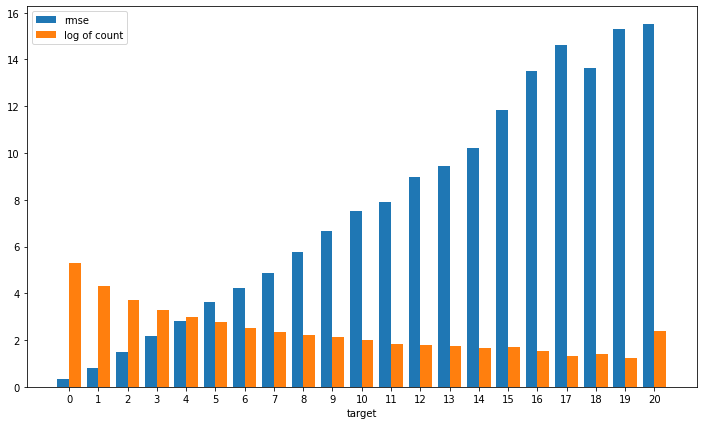

In [16]:
plt.figure(figsize=(12, 7))
plt.bar(errors.index - 0.2, errors.rmse, width=0.4)
plt.bar(errors.index + 0.2, np.log10(errors['count']), width=0.4)
plt.xticks(ticks=errors.index, labels=errors.index)
plt.legend(['rmse', 'log of count'])
plt.xlabel('target')
plt.show()

So the rmse is greater for the greater target value. To figure out what is happening let's see some time series for target equals 19.

In [17]:
XX = X_val[X_val.true == 19]

all_info = items.loc[X.loc[XX.index].item_id].merge(item_cat_names, on='item_category_id')\
    .drop(columns='item_category_id')\
    .assign(shop_name=shops.loc[X.loc[XX.index].shop_id].shop_name.values,
            error=XX.error.values,
           shop_id=X.loc[XX.index].shop_id.values,
           item_id=X.loc[XX.index].item_id.values)
all_info

,item_name,item_category_name,shop_name,error,shop_id,item_id
0,"Ведьмак 3: Дикая Охота - Дополнение ""Каменные ...",Игры - PS4,"Воронеж ТРЦ ""Максимир""",17.975991,7,10202
1,Assassin's Creed: Синдикат. Специальное издани...,Игры - PS4,Выездная Торговля,18.322835,9,9390
2,"Ведьмак 3: Дикая охота [PS4, русская версия]",Игры - PS4,Выездная Торговля,18.674874,9,13308
3,Assassin's Creed: Синдикат. Специальное издани...,Игры - PS4,Выездная Торговля,18.322835,9,11523
4,"Ведьмак 3: Дикая Охота - Дополнение ""Каменные ...",Игры - PS4,"Калуга ТРЦ ""XXI век""",17.710937,15,1583
5,Брелок Южный парк Картман со звуком 12см арт. ...,Подарки - Сувениры (в навеску),"Москва ""Распродажа""",18.432440,20,13239
6,Жетоны Assassin's Creed (железн),Подарки - Сувениры (в навеску),"Москва ""Распродажа""",17.222049,20,21937
7,Комикс Сорвиголова Том 1,"Книги - Комиксы, манга","Москва ТРК ""Атриум""",12.191233,25,10210
8,Комикс Бэтмен Том 2 Город Сов,"Книги - Комиксы, манга","Москва ТЦ ""Семеновский""",17.761052,31,10447
9,Шапка Adventure Time Finn плюшевая,Подарки - Атрибутика,"Москва ТЦ ""Семеновский""",16.937484,31,22001


The histogram of errors

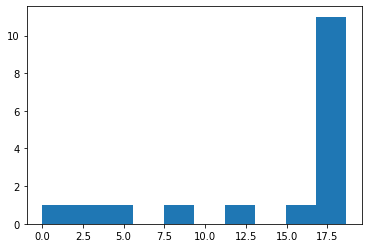

In [18]:
plt.hist(all_info.error)
plt.show()

So the errors are mostly about 17. Let's take a look at the time series for the first row.

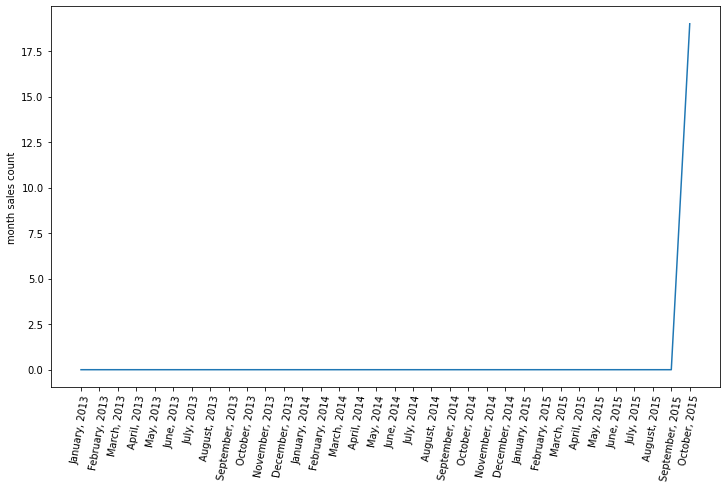

In [19]:
plot_series(7, 10202)

The history of sales contains only zeros but the last month. It explains why the prediction is very different from the true value. In the last row the error equals -0.004435. Let's take a look at this time series.

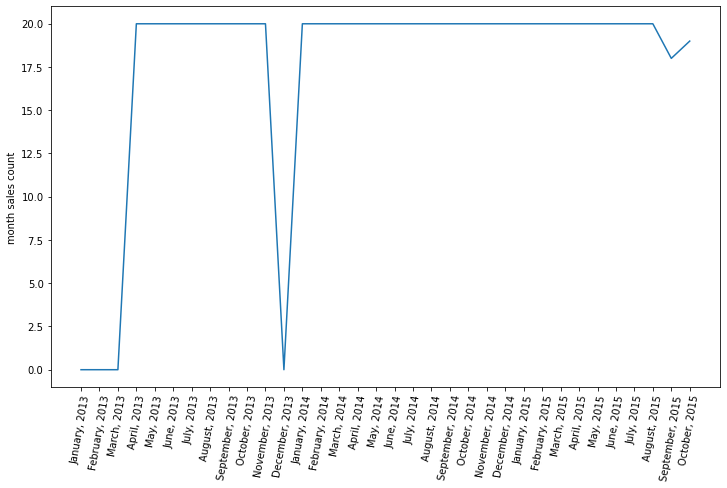

In [20]:
plot_series(59, 20949)

Here the history of sales contains a lot of 20 values. So the predicted value is not very different from the true value.

Based on this I can make a conclusion that a very big error is explained by the "empty" sales history and the big sales count in the last month

Here the errors and counts of rows groupped by different categories

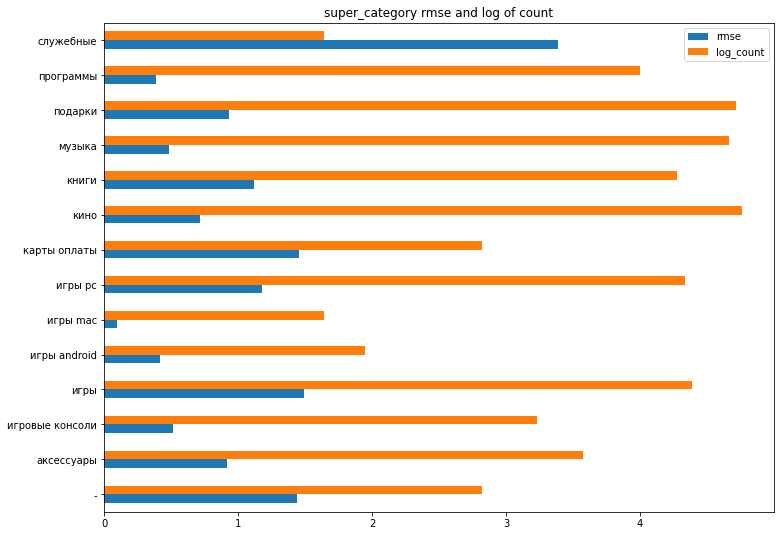

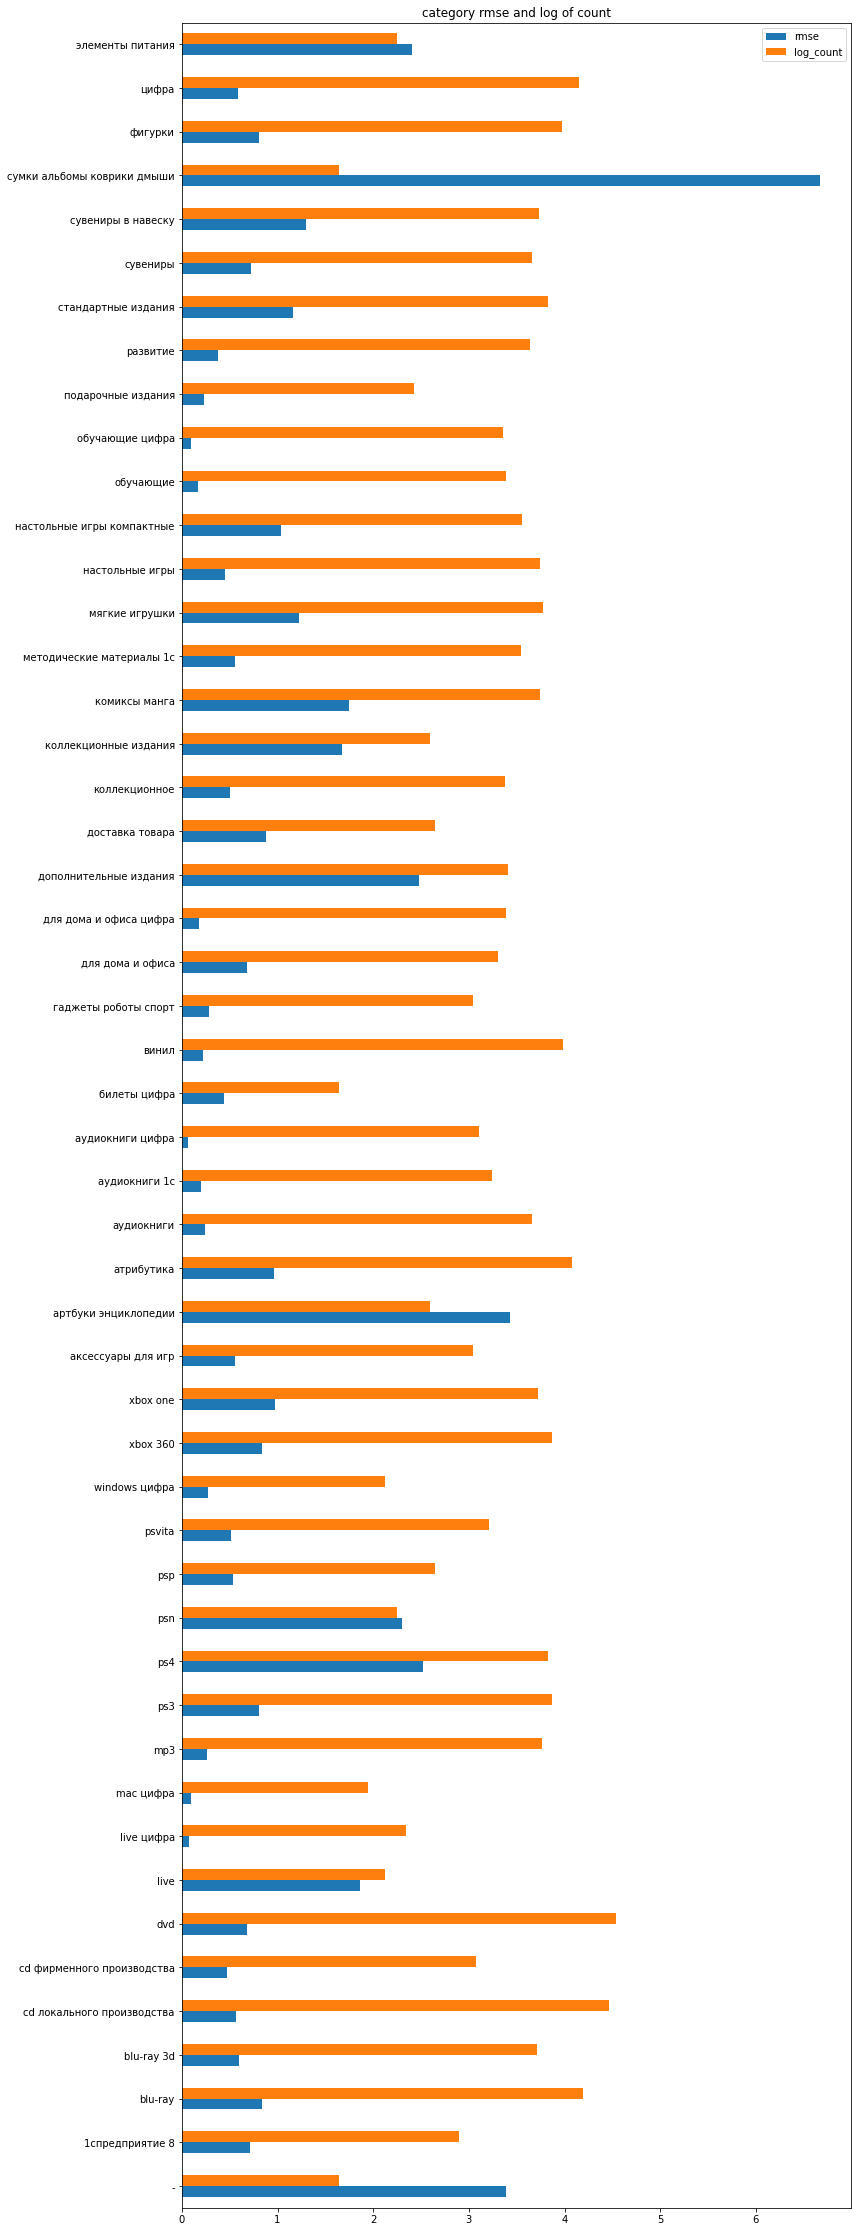

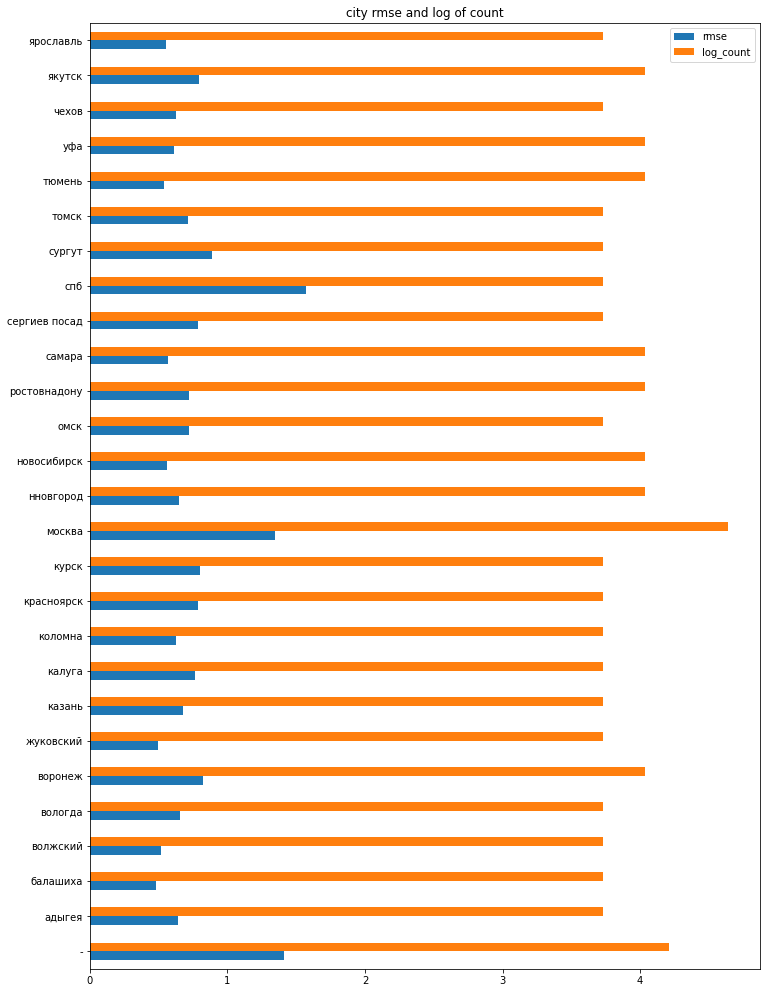

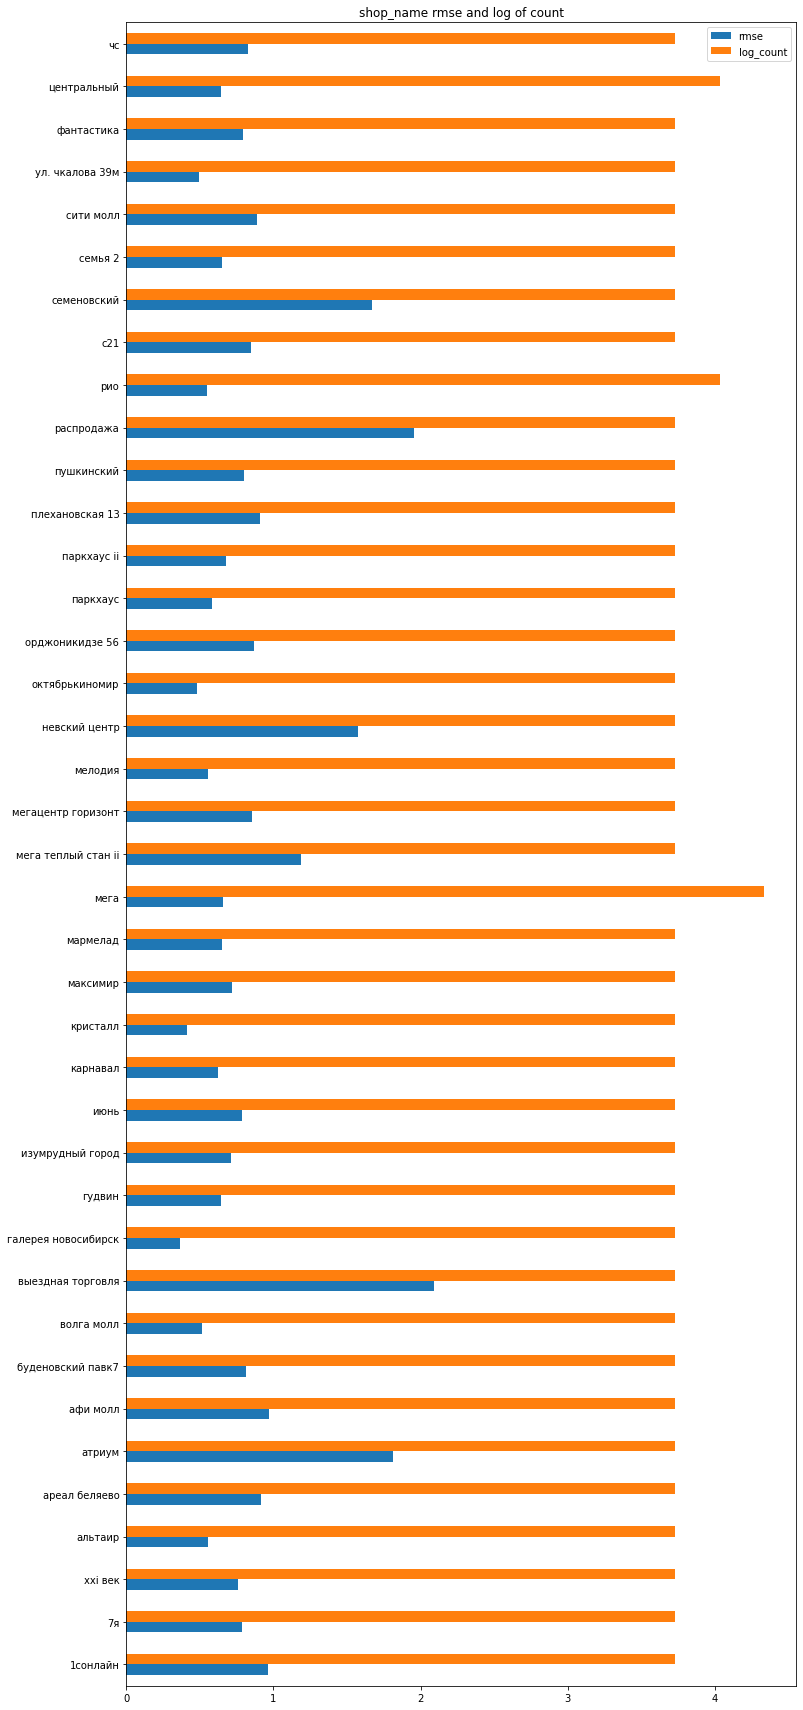

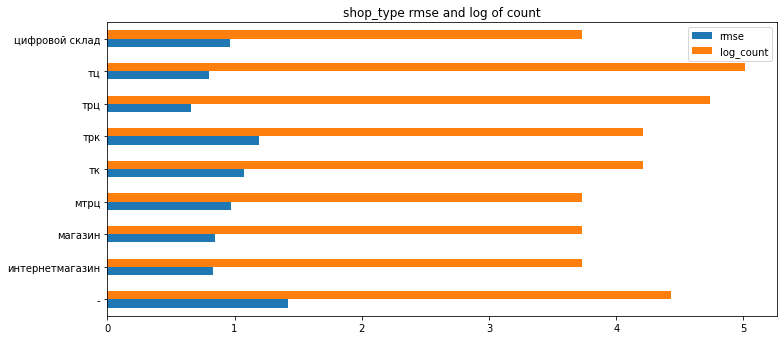

In [21]:
categories = ['super_category', 'category', 'city', 'shop_name', 'shop_type']
cat_dfs = [super_category, category, city, shop_name, shop_type]

for cat, cat_df in zip(categories, cat_dfs):

    cat_errors = X_val.groupby(f'{cat}_id')\
        .agg({'error': [lambda value: (value**2).mean()**0.5, 'count']})['error']\
        .rename(columns={'<lambda_0>': 'rmse'})\
        .merge(cat_df, on=f'{cat}_id')
    cat_errors['log_count'] = np.log10(cat_errors['count'])
    cat_errors.fillna('-').plot(x=cat,
                                y=['rmse', 'log_count'],
                                kind='barh',
                                figsize=(12, 0.6 * len(cat_df)),
                                title=f'{cat} rmse and log of count',
                                xlabel='',)
    plt.show()

The bar plots for rmse of different shops doesn't have any outliers. The count of row are almost the same for all shop types, names and cities. But there are some categories for which the model has a high error. E.g. category 'служебные'. Let's take a look at the plot of mean month sales among all the rows.

In [22]:
super_category[super_category.super_category == 'служебные']

,super_category_id,super_category
14,14,служебные


In [23]:
df = all_series.merge(X_val[X_val.super_category_id == 14][['shop_id', 'item_id', 'predicted', 'error']], on=['shop_id', 'item_id'])

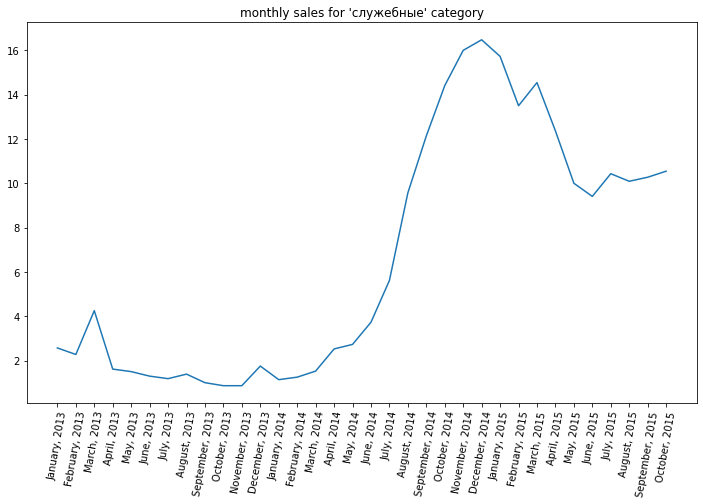

In [24]:
plt.figure(figsize=(12, 7))
plt.plot(df.mean().iloc[2:36])
plt.xticks(range(34), all_month_names, rotation=80)
plt.title("monthly sales for 'служебные' category")
plt.show()

So the history doesn't contain many zeros. It means that the model handles items of this category worse than the others. But the count of such elements is not very high - 44. So it doesn't interfer the result strongly.

Category 'сумки альбомы коврики дмыши' is the same. Let's take a look at the plot for this category.

In [25]:
category[category.category == 'сумки альбомы коврики дмыши']

,category_id,category
60,60,сумки альбомы коврики дмыши


In [26]:
df = all_series.merge(X_val[X_val.category_id == 60][['shop_id', 'item_id', 'predicted', 'error']], on=['shop_id', 'item_id'])

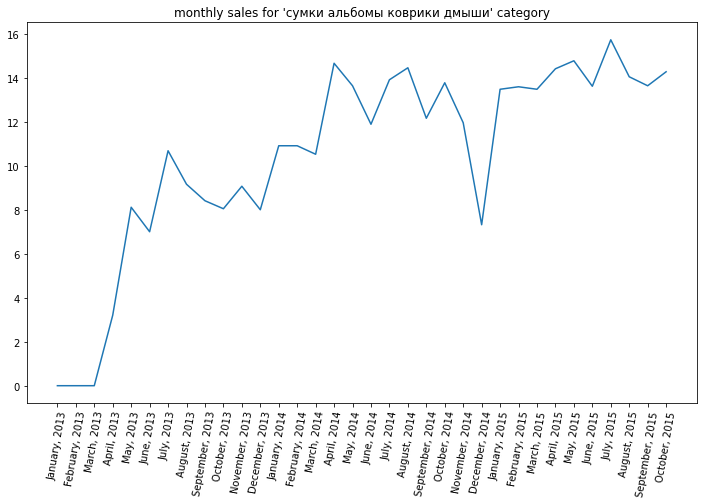

In [27]:
plt.figure(figsize=(12, 7))
plt.plot(df.mean().iloc[2:36])
plt.xticks(range(34), all_month_names, rotation=80)
plt.title("monthly sales for 'сумки альбомы коврики дмыши' category")
plt.show()

The history of sales also doesn't contain many zeros. So this category is predicted by the model worse than others too. But the count of rows equals 44 and as previous category it doesn't interfer the result strongly.